# Experiments: Broad grid of imaging parameters

The following notebook details a set of experiments done in late June on G351.77 B6 SPW5, which contains the 12CO line.

Full spectral window cubes were made of the same data using parameters spanning the following:

 * `perchanweightdensity={True,False}`, specified in the filename with `_T_` or `_F_`
 * `hogbom` clean or multiscale clean.  Multiscale uses scales [0,5,15].  Hogbom is denoted `_h_`, multiscale is `m{-1.0,0.0,1.0}`.
     * the multiscale clean was imaged with smallscalebias = -1, 0, 1.  From the tclean docs: "A score larger than 0.0 will bias the solution towards smaller scales.
A score smaller than 0.0 will bias the solution towards larger scales."
 * `restoringbeam='common' or ''`, denoted as `_common_` or `_perchan_`
 * Two pixel sizes, 0.22 arcsec and 0.13 arcsec, denoted as `_bigpix_` or  `_smallpix_`
 * Two cyclefactors, 1.0 and 2.0.  A larger cyclefactor means more major cycles.  Denoted `_cf1_` and `_cf2_`.
 * Two startmodel options: `_noSM`, no startmodel, and `_SM`, using the continuum startmodel.

In [60]:
from spectral_cube import SpectralCube
from astropy import units as u, coordinates

In [61]:
cd /orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June24_2021/

/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June24_2021


In [114]:
ls -lhrtd *.image

drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 24 16:11 G351.77_B6_spw5_12M_spw5_F_h_common_bigpix_cf1_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 24 16:27 G351.77_B6_spw5_12M_spw5_F_h_perchan_bigpix_cf1_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 24 16:58 G351.77_B6_spw5_12M_spw5_F_h_common_smallpix_cf1_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 24 17:06 G351.77_B6_spw5_12M_spw5_F_h_perchan_smallpix_cf1_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 24 17:22 G351.77_B6_spw5_12M_spw5_F_h_common_bigpix_cf2_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 24 17:39 G351.77_B6_spw5_12M_spw5_F_h_perchan_bigpix_cf2_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 24 19:18 G351.77_B6_spw5_12M_spw5_F_h_common_smallpix_cf2_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 24 19:21 G351.77_B6_spw5_12M_spw5_F_h_perchan_smallpix_cf2_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 24 19:59 G35

In [63]:
import warnings

In [64]:
crd = coordinates.SkyCoord('17:26:40.80 -36:08:53.2', frame='fk5', unit=(u.hour, u.deg))

In [65]:
beams = {}
censpec = {}
mxspec = {}
params = {}
img = {}
spec2 = {}
rms = {}

In [169]:
img31 = {}

In [171]:
spw = 5


for imsize, cell, sznm in ((768, '0.22arcsec', 'bigpix'), ([1080,1024], '0.13arcsec', 'smallpix')):
    for perchanweightdensity in (True, False):
        pcwd = 'T' if perchanweightdensity else 'F'
        for deconvolver in ('hogbom', 'multiscale'):
            dc = 'h' if deconvolver == 'hogbom' else 'm'
            for restoringbeam in ('', 'common'):
                rb = 'common' if restoringbeam == 'common' else 'perchan'
                for cyclefactor in (1.0, 2.0):
                    for startmodel in (f"/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/imaging_results/G351.77_B6_spw{spw}_12M_spw{spw}.contcube.model", ""):
                        sm = "SM" if startmodel else "noSM"
                        for briggs in ('briggs', 'briggsbwtaper', ''):
                            bwt = '_bwt' if briggs == 'briggsbwtaper' else '_rob'
                            if briggs == '':
                                bwt = ''


                            for smallscalebias in (-1.0, 0.0, 1.0):
                                if deconvolver == 'multiscale':
                                    dc = 'm'+str(smallscalebias)
                                else:
                                    dc = 'h'
                                imname = f"/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June24_2021/G351.77_B6_spw{spw}_12M_spw{spw}_{pcwd}_{dc}_{rb}_{sznm}_cf{int(cyclefactor)}{bwt}_{sm}"
                                hd = f"spw{spw}_{pcwd}_{dc}_{rb}_{sznm}_cf{int(cyclefactor)}{bwt}_{sm}"

                                params[hd] = {'imsize': imsize,
                                              'cell': cell,
                                              'perchanweightdensity': perchanweightdensity,
                                              'deconvolver': deconvolver,
                                              'restoringbeam': restoringbeam,
                                              'cyclefactor': cyclefactor,
                                              'startmodel': sm,
                                              'smallscalebias': smallscalebias}

                                if os.path.exists(imname+".image") and hd not in img31:
                                    with warnings.catch_warnings():
                                        warnings.simplefilter('ignore')
                                        cube = SpectralCube.read(imname+".image").with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=230.530*u.GHz)
                                        cube = cube.with_mask(cube>-9999*cube.unit) # HACK - error
                                        if hasattr(cube, 'beams'):
                                            beams[hd] = cube.beams
                                        else:
                                            beams[hd] = cube.beam
                                        censpec[hd] = cube[:,cube.shape[1]//2,cube.shape[2]//2]
                                        xpx,ypx = cube.wcs.celestial.wcs_world2pix(crd.ra.deg, crd.dec.deg, 0)
                                        spec2[hd] = cube[:, int(ypx), int(xpx)]
                                        img[hd] = cube[cube.closest_spectral_channel(-20*u.km/u.s),:,:]
                                        img31[hd] = cube[cube.closest_spectral_channel(-31*u.km/u.s),:,:]
                                        rms[hd] = cube[10:20,:,:].mad_std()
                                        # takes too long mxspec[hd] = cube.max(axis=(1,2))
                                        print(imname, hd)

/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June24_2021/G351.77_B6_spw5_12M_spw5_T_h_perchan_bigpix_cf1_SM spw5_T_h_perchan_bigpix_cf1_SM
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June24_2021/G351.77_B6_spw5_12M_spw5_T_h_perchan_bigpix_cf1_noSM spw5_T_h_perchan_bigpix_cf1_noSM
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June24_2021/G351.77_B6_spw5_12M_spw5_T_h_perchan_bigpix_cf2_noSM spw5_T_h_perchan_bigpix_cf2_noSM
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June24_2021/G351.77_B6_spw5_12M_spw5_T_h_common_bigpix_cf1_SM spw5_T_h_common_bigpix_cf1_SM
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June24_2021/G351.77_B6_spw5_12M_spw5_T_h_common_bigpix_cf1_noSM spw5_T_h_common_bigpix_cf1_noSM
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June24_2021/G351.77_B6_spw5_12M_spw5_T_h_common_bigpix_cf2_SM spw5_T_h_common_bigpix_cf2_SM
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June24_2021/G351.77_B6_s

In [173]:
len(params)

384

In [156]:
import pylab as pl
pl.rcParams['figure.facecolor'] = (1,1,1,1)

# Conclusion 1: perchanweightdensity=True results in larger, but consistent beams

See the figure below.  The dashed lines use `perchanweightdensity=True`.

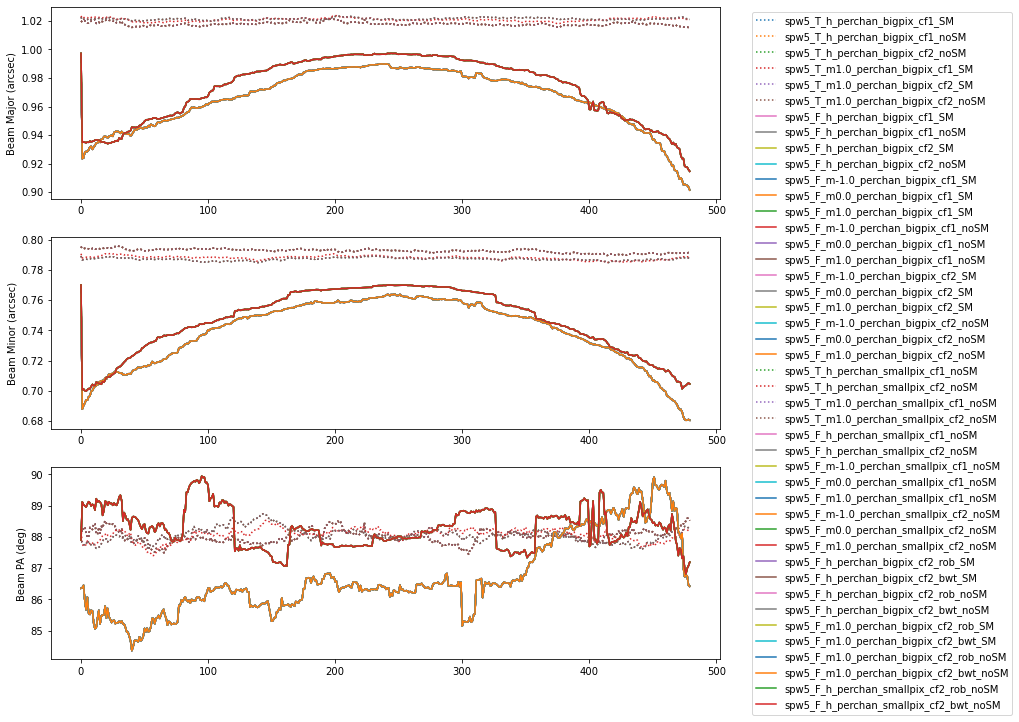

In [157]:
pl.figure(figsize=(12,12))
ax1 = pl.subplot(3,1,1)
ax2 = pl.subplot(3,1,2)
ax3 = pl.subplot(3,1,3)
for hd in beams:
    if np.isscalar(beams[hd].sr.value):
        pass
        #ax1.plot([0,500], [beams[hd].major.value]*2, label=hd, linestyle='--')
        #ax2.plot([0,500], [beams[hd].minor.value]*2, label=hd, linestyle=':')
        #ax3.plot([0,500], [beams[hd].pa.to(u.deg).value]*2, label=hd, linestyle='--')
    else:
        ax1.plot(beams[hd].major, label=hd, linestyle=':' if '_T_' in hd else '-')
        ax2.plot(beams[hd].minor, label=hd, linestyle=':' if '_T_' in hd else '-')
        ax3.plot(beams[hd].pa.to(u.deg).value, label=hd, linestyle=':' if '_T_' in hd else '-')
ax1.set_ylabel("Beam Major (arcsec)")
ax2.set_ylabel("Beam Minor (arcsec)")
ax3.set_ylabel("Beam PA (deg)")
pl.sca(ax1)
pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# Conclusion 2: There are cases that diverge significantly.

The images below show the image at -20 km/s.


Multiscale, with smallscalebias=0.0 or -1.0, results in clear divergence when using pixel size 0.22 arcsec.

Either reducing the pixel size, changing to smallscalebias=1, or using hogbom clean seems to prevent this divergence.

There are also less obvious signs of images starting to diverge, but not quite going totally bad, in several of the hogbom cleans.

Overall, the smaller pixel sizes seem to work a little better, but multiscale with smallscale bias (and cf=2) appears to perform best, in this snapshot:

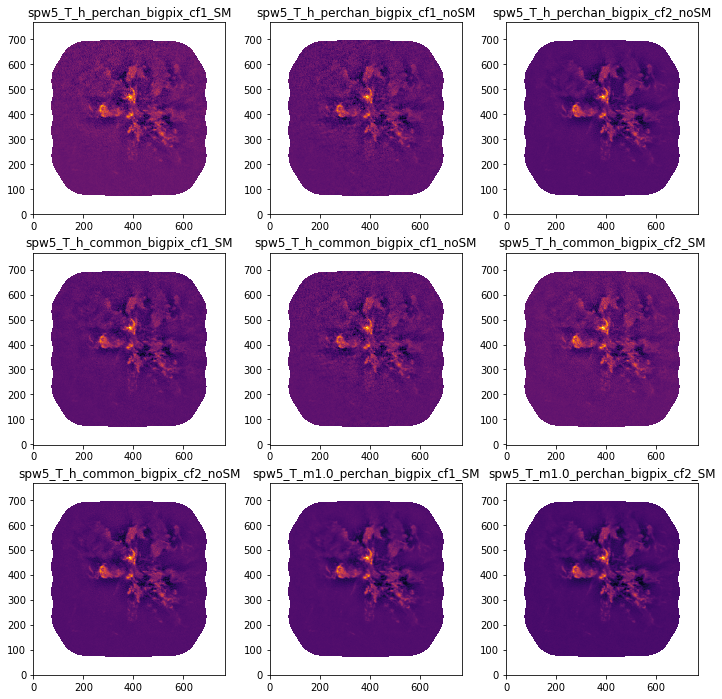

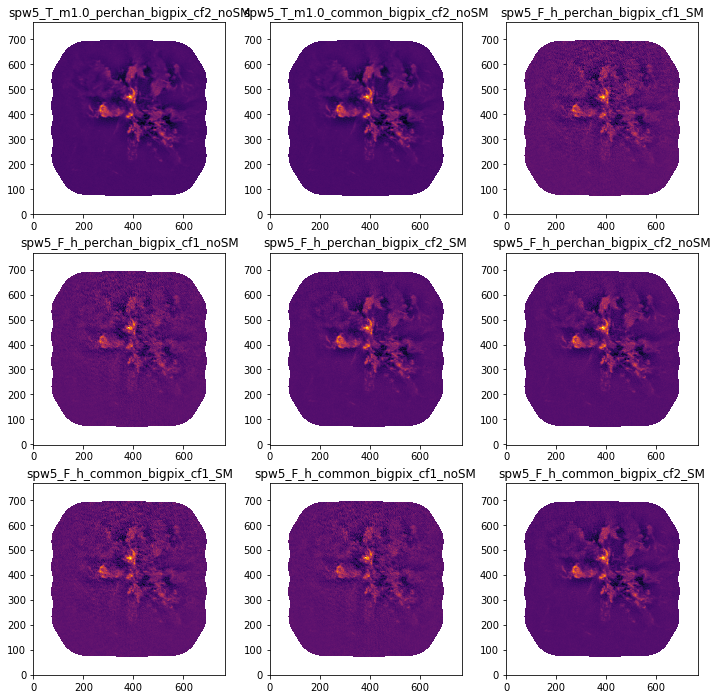

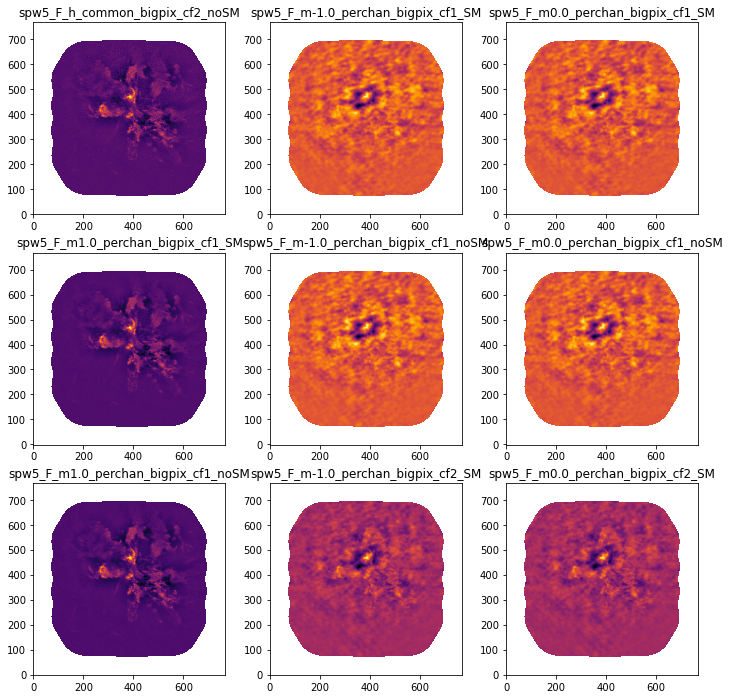

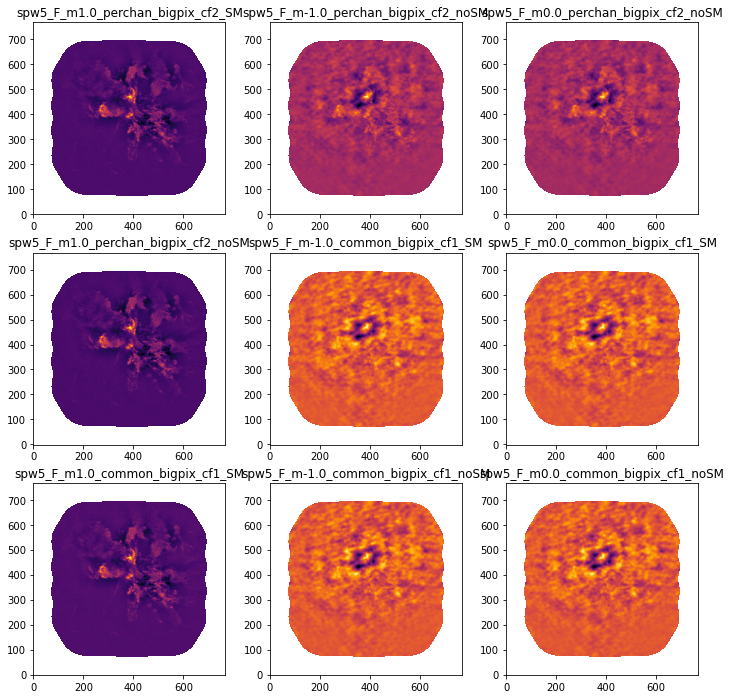

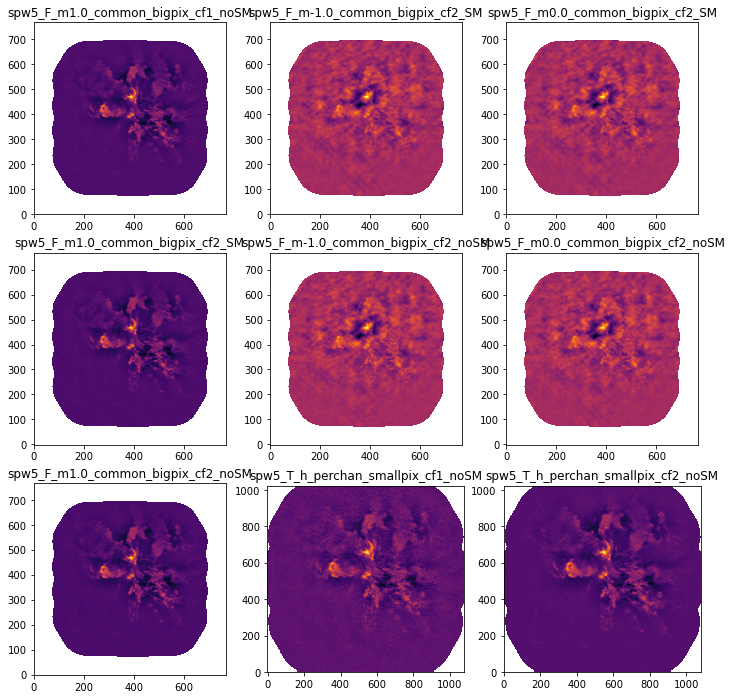

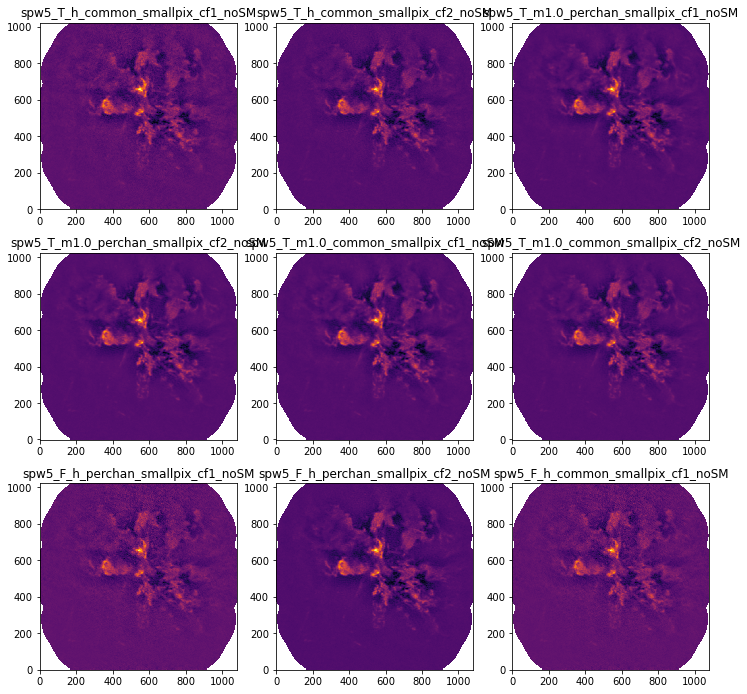

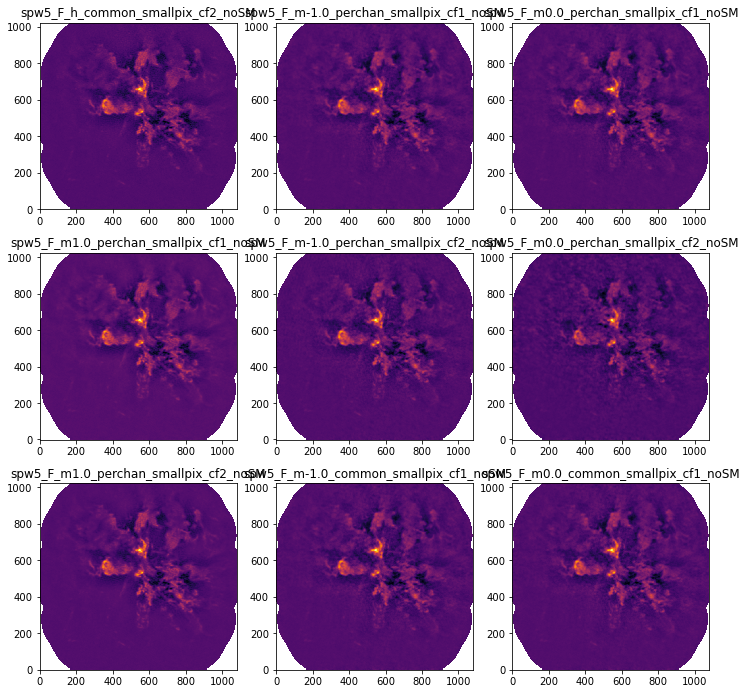

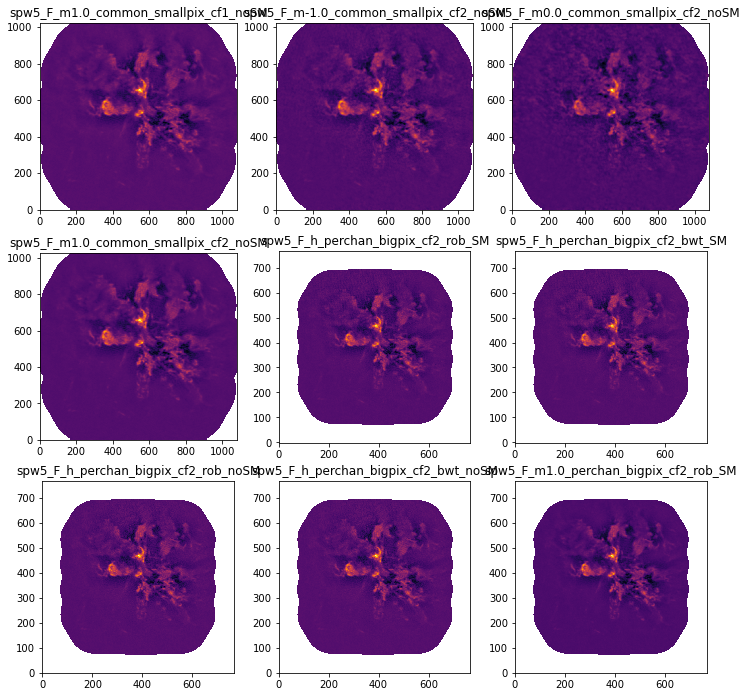

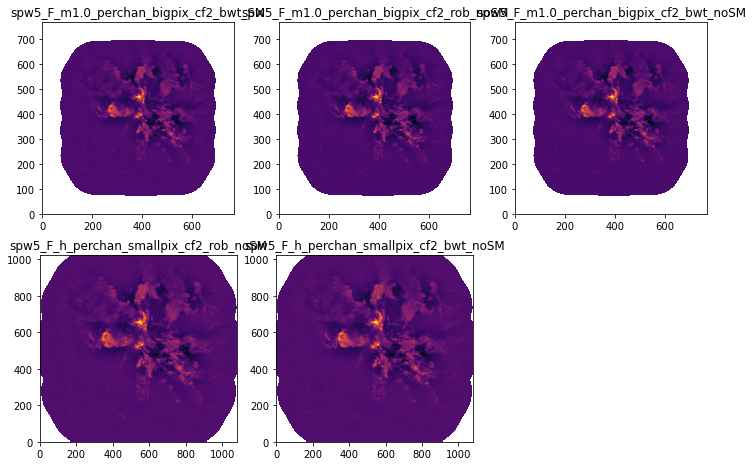

In [158]:
for ii,hd in enumerate(img):
    if ii % 9 == 0:
        pl.figure(figsize=(12,12))
    pl.subplot(3,3,ii%9+1).imshow(img[hd].value, origin='lower', interpolation='none', cmap='inferno')
    pl.title(hd)

# A closer examination of parameters

In the next plot, the value of the pixel at 10 km/s at the center of the image is shown

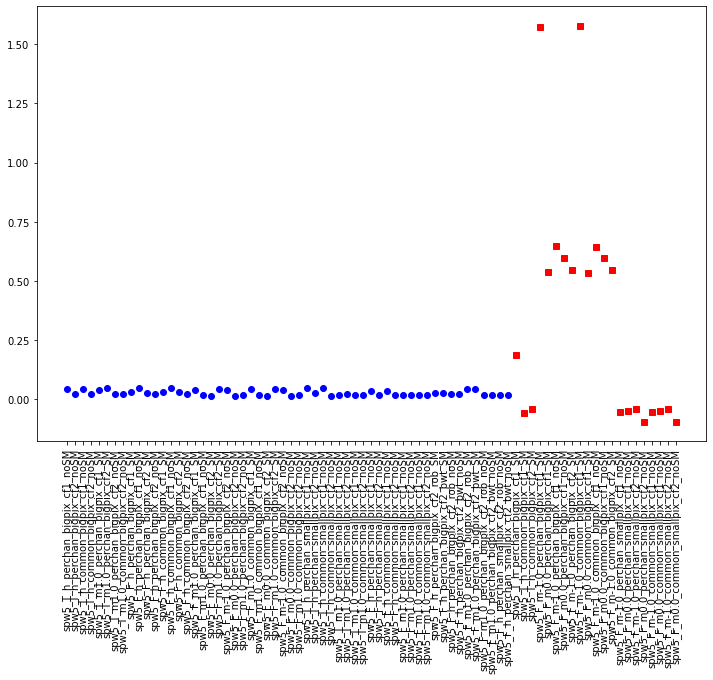

In [159]:
pl.figure(figsize=(12,8))
hdl = [hd for hd in censpec]
xx = np.array([hd for hd in hdl])
yy = np.array([censpec[hd][cube.closest_spectral_channel(10*u.km/u.s)].value for hd in hdl])
ok = (yy > 0) & (yy < 0.1)
pl.plot(xx[ok], yy[ok], 'bo')
pl.plot(xx[~ok], yy[~ok], 'rs')
_=pl.xticks(rotation=90)

The clearly diverged parameters are:

(1) Mostly `perchanweightdensity=False`.  PCWD=True + Hogbom + startmodel seemed not to work well.
(2) Exclusively multiscale with zero or negative smallscalebias.

In [160]:
xx[~ok]

array(['spw5_T_h_perchan_bigpix_cf1_SM', 'spw5_T_h_common_bigpix_cf1_SM',
       'spw5_T_h_common_bigpix_cf2_SM',
       'spw5_F_m-1.0_perchan_bigpix_cf1_SM',
       'spw5_F_m0.0_perchan_bigpix_cf1_SM',
       'spw5_F_m-1.0_perchan_bigpix_cf1_noSM',
       'spw5_F_m0.0_perchan_bigpix_cf1_noSM',
       'spw5_F_m-1.0_perchan_bigpix_cf2_SM',
       'spw5_F_m-1.0_common_bigpix_cf1_SM',
       'spw5_F_m0.0_common_bigpix_cf1_SM',
       'spw5_F_m-1.0_common_bigpix_cf1_noSM',
       'spw5_F_m0.0_common_bigpix_cf1_noSM',
       'spw5_F_m-1.0_common_bigpix_cf2_SM',
       'spw5_F_m-1.0_perchan_smallpix_cf1_noSM',
       'spw5_F_m0.0_perchan_smallpix_cf1_noSM',
       'spw5_F_m-1.0_perchan_smallpix_cf2_noSM',
       'spw5_F_m0.0_perchan_smallpix_cf2_noSM',
       'spw5_F_m-1.0_common_smallpix_cf1_noSM',
       'spw5_F_m0.0_common_smallpix_cf1_noSM',
       'spw5_F_m-1.0_common_smallpix_cf2_noSM',
       'spw5_F_m0.0_common_smallpix_cf2_noSM'], dtype='<U39')

This plot shows the spectra at the central pixel for all images.  The color coding is hard to decipher, but you can see that only some channels diverge, which is how I selected 10 km/s above.

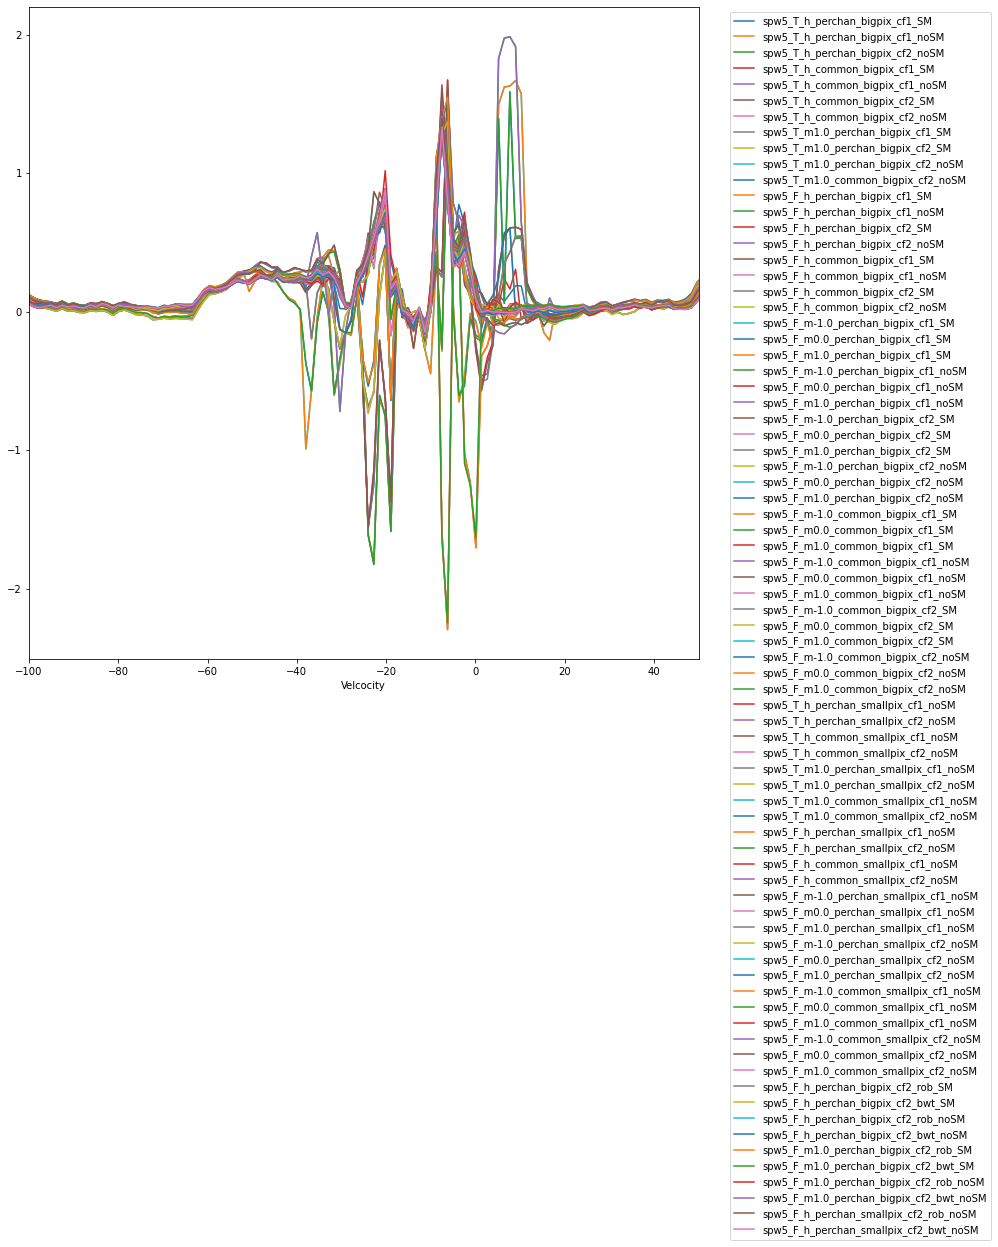

In [161]:
pl.figure(figsize=(12,12))
for hd in censpec:
    pl.plot(censpec[hd].spectral_axis, censpec[hd].value, label=hd)
pl.xlim(-100,50)
pl.xlabel("Velcocity")
pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# Analysis of another spectrum & point

This spectrum has bigger problems aroud -19 and -31 km/s

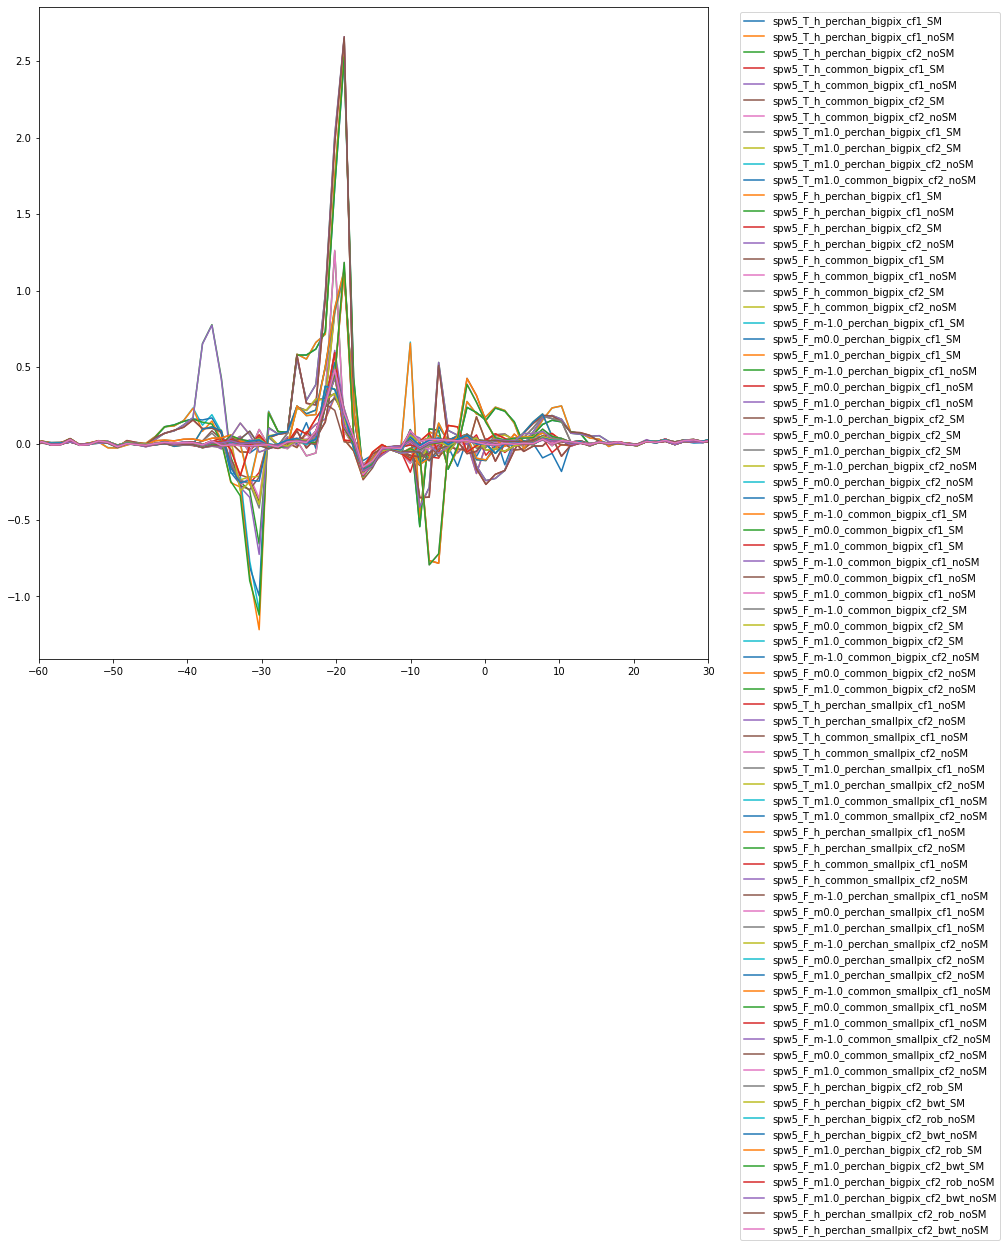

In [162]:
pl.figure(figsize=(12,12))
for hd in spec2:
    pl.plot(spec2[hd].spectral_axis, spec2[hd].value, label=hd)
pl.xlim(-60,30)
pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")

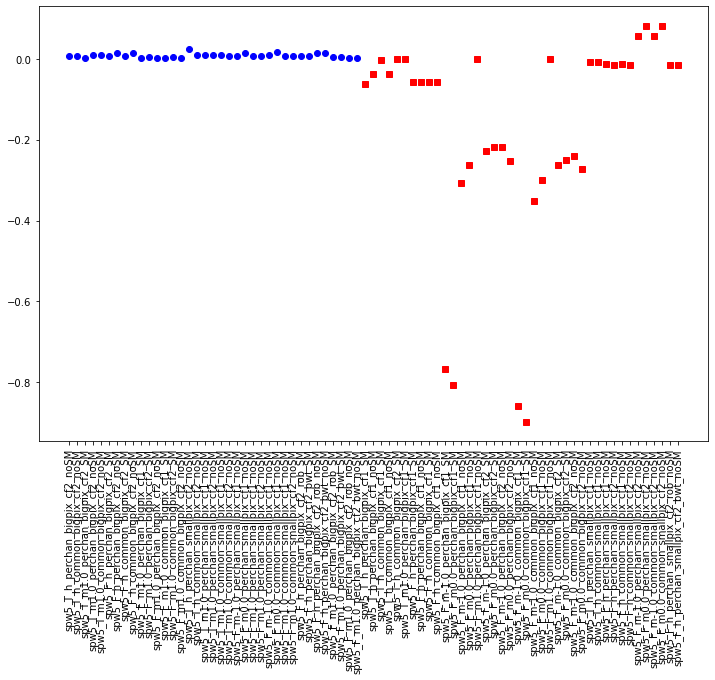

In [163]:
pl.figure(figsize=(12,8))
hdl = [hd for hd in censpec]
xx = np.array([hd for hd in hdl])
yy = np.array([spec2[hd][cube.closest_spectral_channel(-31*u.km/u.s)].value for hd in hdl])
ok = (yy > 0) & (yy < 0.05)
pl.plot(xx[ok], yy[ok], 'bo')
pl.plot(xx[~ok], yy[~ok], 'rs')
_=pl.xticks(rotation=90)

The only parameter combination that doesn't show up in the failures is `cf2` + `m1`

In [164]:
# bad
xx[~ok]

array(['spw5_T_h_perchan_bigpix_cf1_SM',
       'spw5_T_h_perchan_bigpix_cf1_noSM',
       'spw5_T_h_common_bigpix_cf1_SM', 'spw5_T_h_common_bigpix_cf1_noSM',
       'spw5_T_h_common_bigpix_cf2_SM',
       'spw5_T_m1.0_perchan_bigpix_cf1_SM',
       'spw5_F_h_perchan_bigpix_cf1_SM',
       'spw5_F_h_perchan_bigpix_cf1_noSM',
       'spw5_F_h_common_bigpix_cf1_SM', 'spw5_F_h_common_bigpix_cf1_noSM',
       'spw5_F_m-1.0_perchan_bigpix_cf1_SM',
       'spw5_F_m0.0_perchan_bigpix_cf1_SM',
       'spw5_F_m-1.0_perchan_bigpix_cf1_noSM',
       'spw5_F_m0.0_perchan_bigpix_cf1_noSM',
       'spw5_F_m1.0_perchan_bigpix_cf1_noSM',
       'spw5_F_m-1.0_perchan_bigpix_cf2_SM',
       'spw5_F_m0.0_perchan_bigpix_cf2_SM',
       'spw5_F_m-1.0_perchan_bigpix_cf2_noSM',
       'spw5_F_m0.0_perchan_bigpix_cf2_noSM',
       'spw5_F_m-1.0_common_bigpix_cf1_SM',
       'spw5_F_m0.0_common_bigpix_cf1_SM',
       'spw5_F_m-1.0_common_bigpix_cf1_noSM',
       'spw5_F_m0.0_common_bigpix_cf1_noSM',
       'sp

In [165]:
# good
xx[ok]

array(['spw5_T_h_perchan_bigpix_cf2_noSM',
       'spw5_T_h_common_bigpix_cf2_noSM',
       'spw5_T_m1.0_perchan_bigpix_cf2_SM',
       'spw5_T_m1.0_perchan_bigpix_cf2_noSM',
       'spw5_T_m1.0_common_bigpix_cf2_noSM',
       'spw5_F_h_perchan_bigpix_cf2_SM',
       'spw5_F_h_perchan_bigpix_cf2_noSM',
       'spw5_F_h_common_bigpix_cf2_SM', 'spw5_F_h_common_bigpix_cf2_noSM',
       'spw5_F_m1.0_perchan_bigpix_cf1_SM',
       'spw5_F_m1.0_perchan_bigpix_cf2_SM',
       'spw5_F_m1.0_perchan_bigpix_cf2_noSM',
       'spw5_F_m1.0_common_bigpix_cf1_SM',
       'spw5_F_m1.0_common_bigpix_cf2_SM',
       'spw5_F_m1.0_common_bigpix_cf2_noSM',
       'spw5_T_h_perchan_smallpix_cf2_noSM',
       'spw5_T_h_common_smallpix_cf2_noSM',
       'spw5_T_m1.0_perchan_smallpix_cf1_noSM',
       'spw5_T_m1.0_perchan_smallpix_cf2_noSM',
       'spw5_T_m1.0_common_smallpix_cf1_noSM',
       'spw5_T_m1.0_common_smallpix_cf2_noSM',
       'spw5_F_m-1.0_perchan_smallpix_cf1_noSM',
       'spw5_F_m0.0_perchan_

# RMS

These plots show the measured RMS for each of the reductions.  The first is the raw RMS:

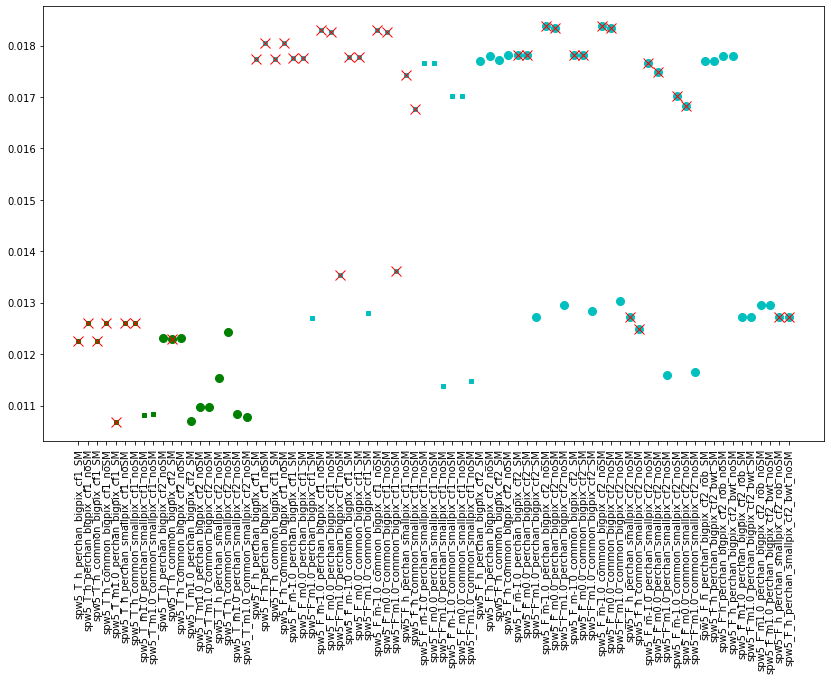

In [166]:
pl.figure(figsize=(14,8))
hdl = [hd for hd in censpec]
xx = np.array([hd for hd in hdl])
yy = np.array([rms[hd].value for hd in hdl])
#ok = (yy > 0.00) & (yy < 0.25)
colors = {'_T_': 'g', '_F_': 'c'}
shapes = {"cf1":'s', 'cf2': 'o'}
sz = {'cf1': 4, 'cf2': 8}
for cc in colors:
    for ss in shapes:
        for size in sz:
            sel = np.array([(ss in hd) and (cc in hd) and (size in hd) for hd in hdl], dtype='bool')
            pl.plot(xx[sel], yy[sel], color=colors[cc], marker=shapes[ss], markersize=sz[size], linestyle='none')
            pl.plot(xx[sel&~ok], yy[sel&~ok], color='r', marker='x', markersize=10, linestyle='none')
_=pl.xticks(rotation=90)

...the second is the RMS divided by the beam area (so the Y-axis is arbitrary)

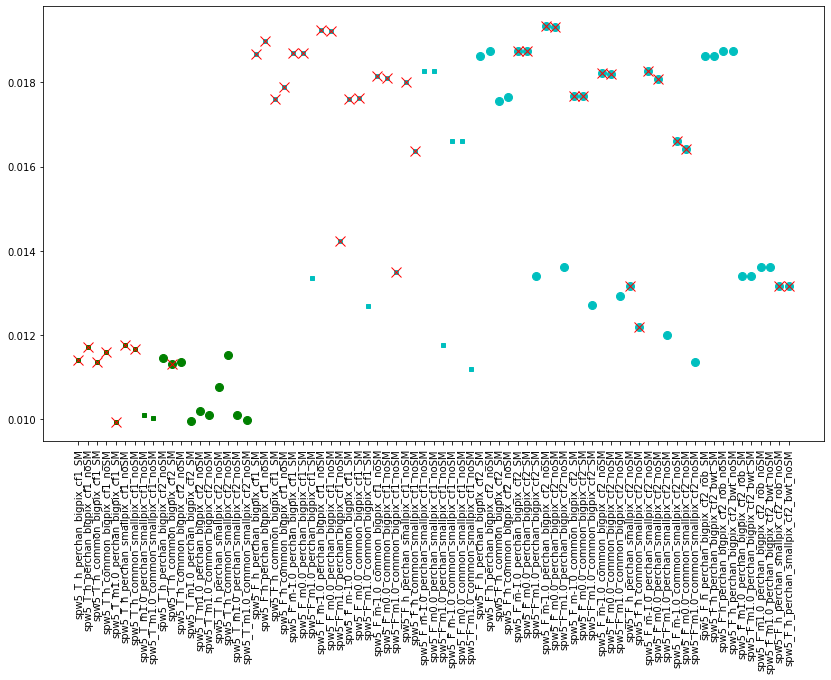

In [167]:
pl.figure(figsize=(14,8))
hdl = [hd for hd in censpec]
xx = np.array([hd for hd in hdl])
yy = np.array([rms[hd].value/beams[hd].mean().value*2e-11 for hd in hdl])
for cc in colors:
    for ss in shapes:
        for size in sz:
            sel = np.array([(ss in hd) and (cc in hd) and (size in hd) for hd in hdl], dtype='bool')
            pl.plot(xx[sel], yy[sel], color=colors[cc], marker=shapes[ss], markersize=sz[size], linestyle='none')
            pl.plot(xx[sel&~ok], yy[sel&~ok], color='r', marker='x', markersize=10, linestyle='none')
_=pl.xticks(rotation=90)

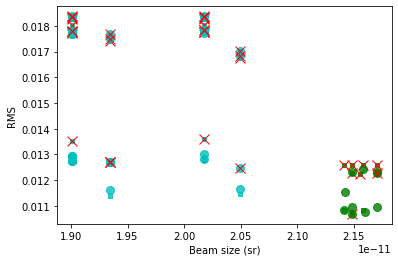

In [168]:
xx = np.array([beams[hd].mean().value for hd in hdl])
yy = np.array([rms[hd].value for hd in hdl])
for cc in colors:
    for ss in shapes:
        for size in sz:
            sel = np.array([(ss in hd) and (cc in hd) and (size in hd) for hd in hdl], dtype='bool')
            pl.plot(xx[sel], yy[sel], color=colors[cc], marker=shapes[ss], markersize=sz[size], linestyle='none', alpha=0.8)
            pl.plot(xx[sel&~ok], yy[sel&~ok], color='r', marker='x', markersize=10, linestyle='none')
_=pl.xlabel("Beam size (sr)")
_=pl.ylabel("RMS")

# Show the -31 km/s channel, which was often problematic

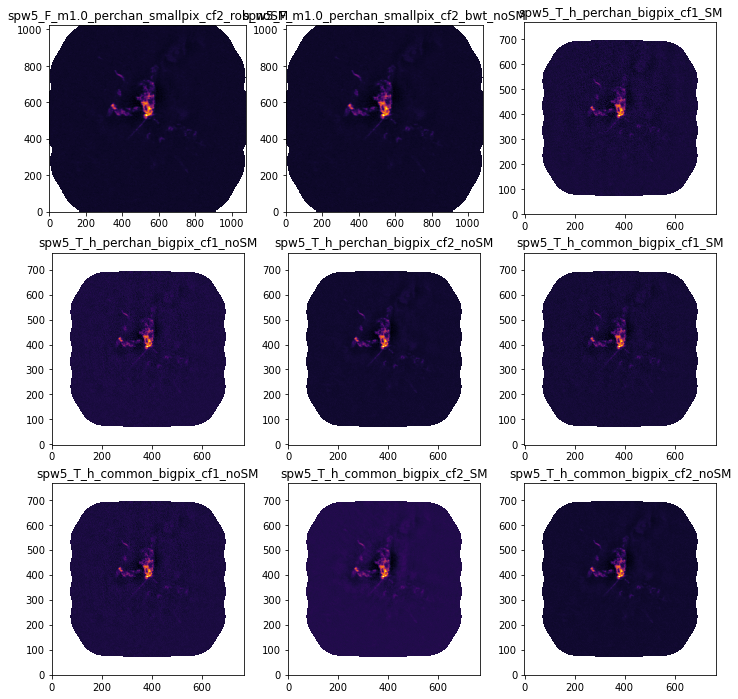

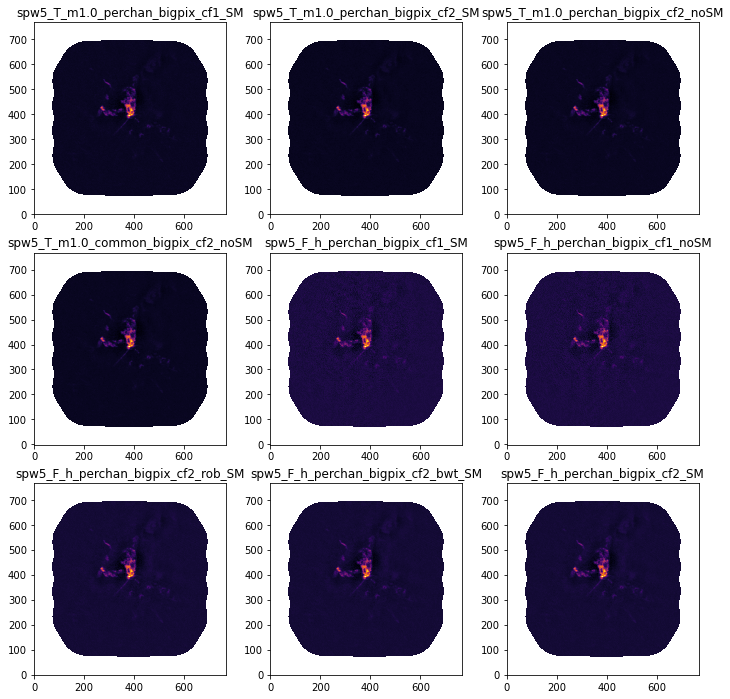

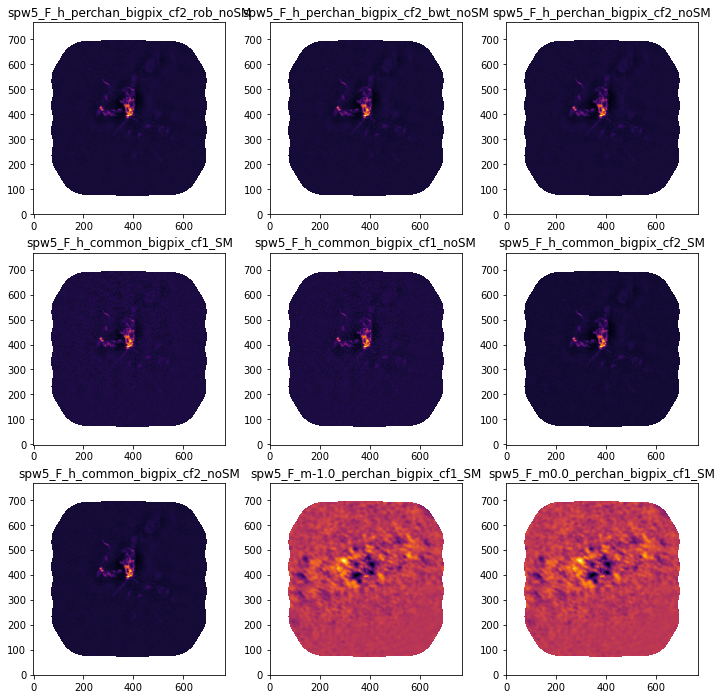

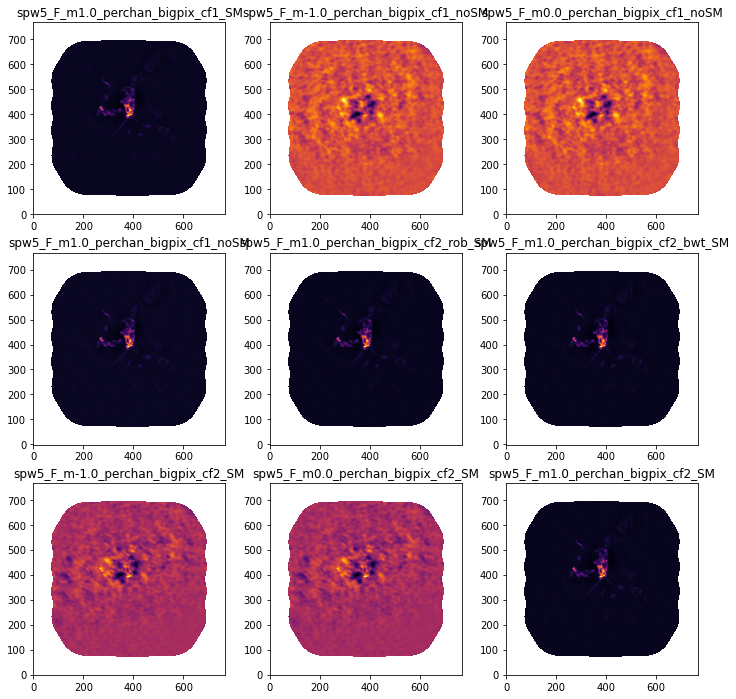

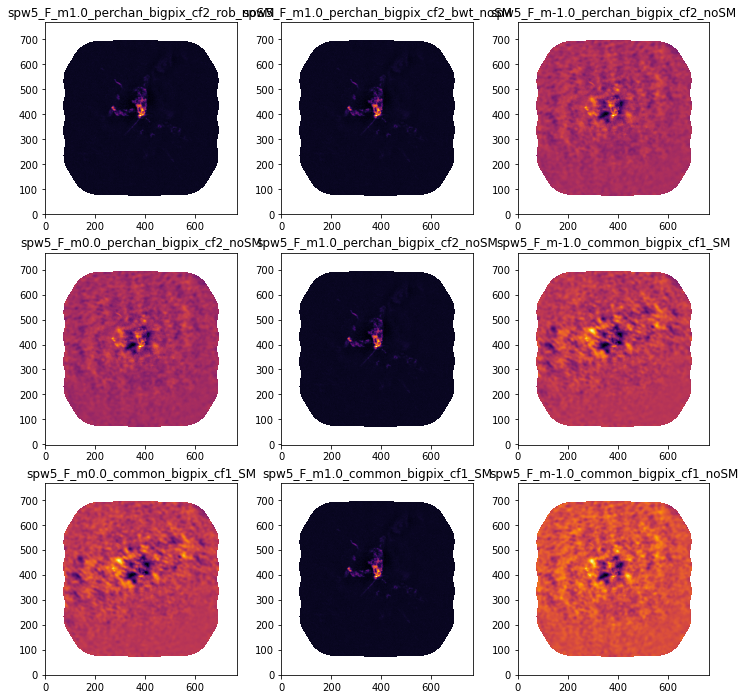

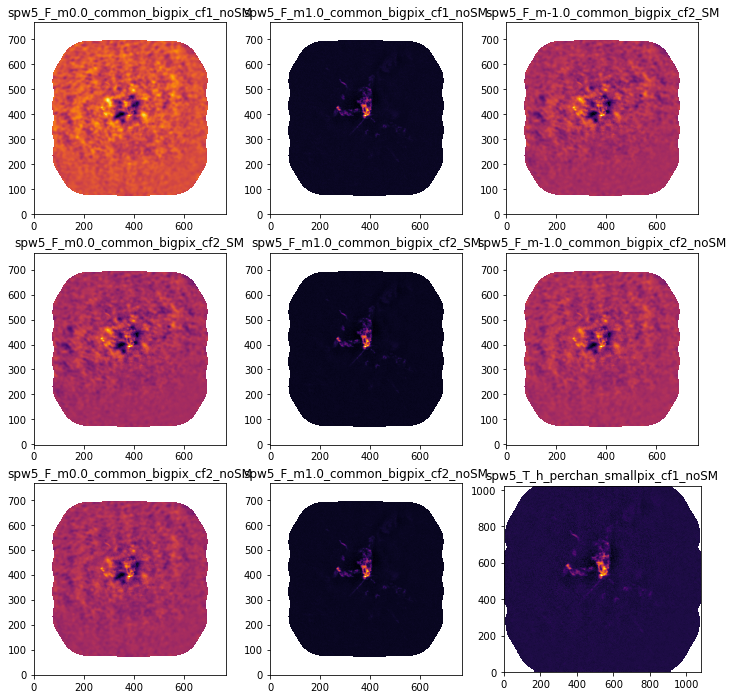

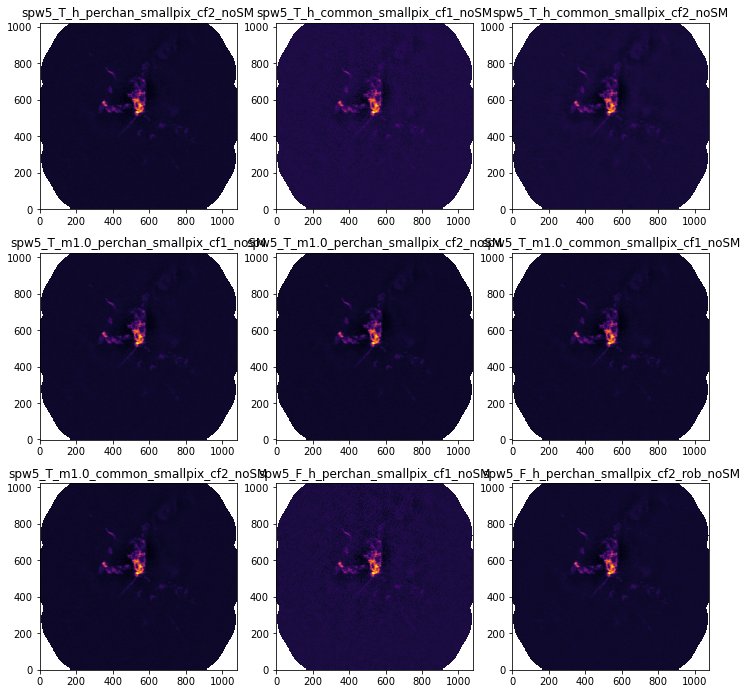

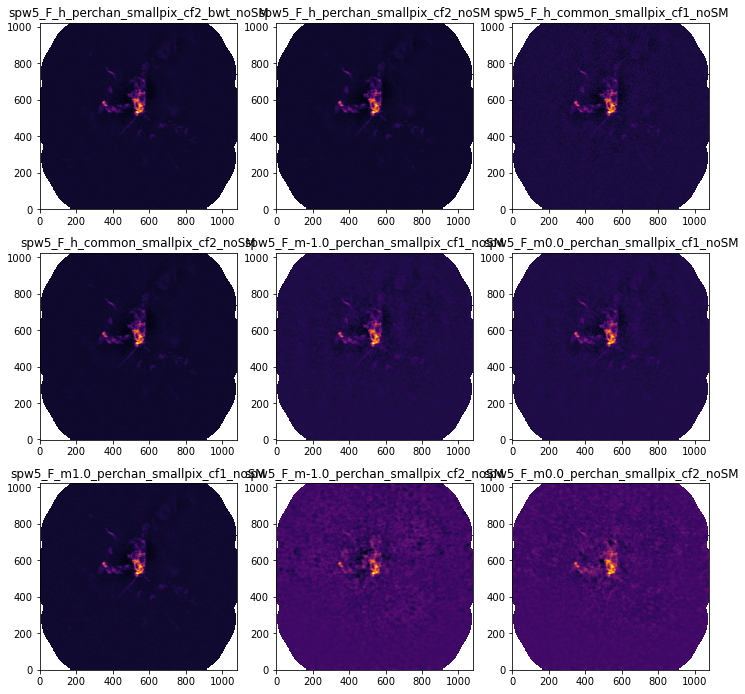

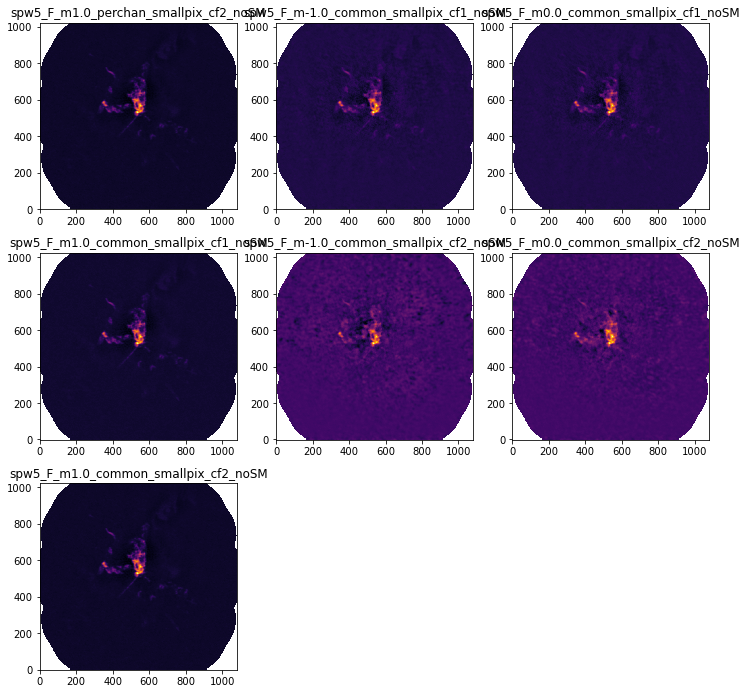

In [172]:
for ii,hd in enumerate(img31):
    if ii % 9 == 0:
        pl.figure(figsize=(12,12))
    pl.subplot(3,3,ii%9+1).imshow(img31[hd].value, origin='lower', interpolation='none', cmap='inferno')
    pl.title(hd)